
### 3. Feature Selection
- **Correlation analysis:** 
- **Feature importance:** 

### 4. Model Selection
- **Train multiple models:**  
- **Compare performance:** 

### 5. Hyperparameter Tuning
- **Grid Search or Random Search:** 
- **Cross-validation:** 

### 6. Evaluation
- **Final evaluation:** 
- **Confusion matrix:** 

### 7. Deployment
- **Streamlit:** 
- **User interface:** 


In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Section 1: Data Loading and Missing Value Checks

Missing Values:
job           39
marital       11
education    167
default      803
housing      105
loan         105
dtype: int64

Percentage of Missing Values:
job           0.946832
marital       0.267055
education     4.054382
default      19.495023
housing       2.549162
loan          2.549162
dtype: float64


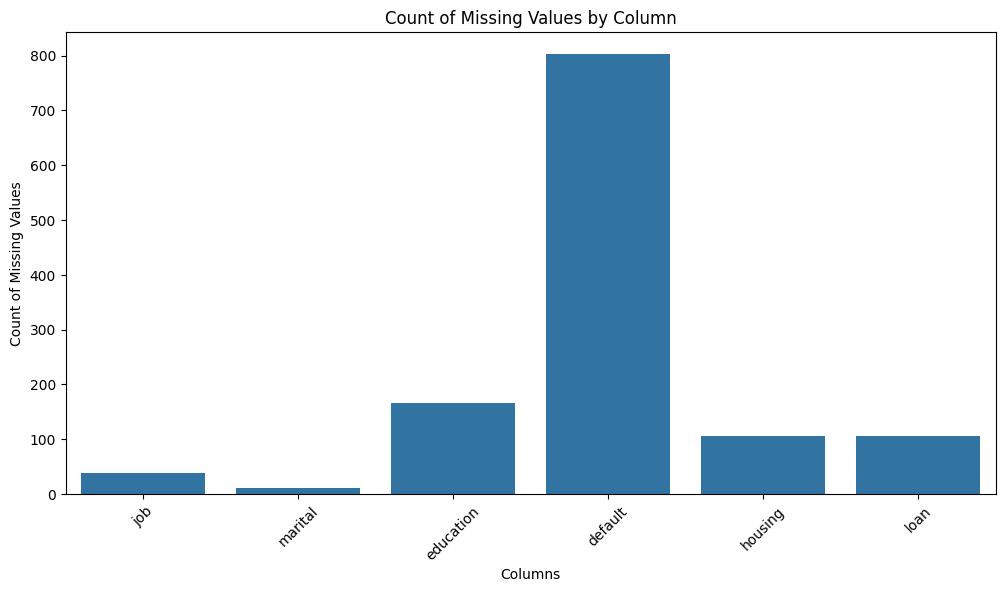

In [2]:
# Function to load data
def load_data(file_path):
    return pd.read_csv(file_path, sep=';')

# Function to check for missing values
def check_missing_values(data):
    missing_values = data.isin(['unknown']).sum()
    missing_values = missing_values[missing_values > 0]
    print("Missing Values:")
    print(missing_values)
    return data, missing_values

# Function to calculate percentage of missing values
def calculate_missing_percentage(data_missing):
    data, missing_values = data_missing
    missing_percentage = (missing_values / len(data)) * 100
    print("\nPercentage of Missing Values:")
    print(missing_percentage)
    return data, missing_values, missing_percentage

# Function to visualize missing values
def visualize_missing_values(data_missing_percentage):
    data, missing_values, missing_percentage = data_missing_percentage
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing_values.index, y=missing_values.values)
    plt.title('Count of Missing Values by Column')
    plt.ylabel('Count of Missing Values')
    plt.xlabel('Columns')
    plt.xticks(rotation=45)
    plt.show()
    return data

# Create pipeline
pipeline = Pipeline([
    ('load_data', FunctionTransformer(lambda _: load_data('dataset/bank-additional.csv'), validate=False)),
    ('check_missing_values', FunctionTransformer(check_missing_values, validate=False)),
    ('calculate_missing_percentage', FunctionTransformer(calculate_missing_percentage, validate=False)),
    ('visualize_missing_values', FunctionTransformer(visualize_missing_values, validate=False))
])

data = pipeline.fit_transform(None)

# Section 1.1: Missing Value Analysis

Missing Values:
job           39
marital       11
education    167
default      803
housing      105
loan         105
dtype: int64
job (missing: 39)
Proportion of 'yes' for missing vs non-missing:
Missing: 10.26%
Non-missing: 10.96%
Difference in proportion: -0.70%

marital (missing: 11)
Proportion of 'yes' for missing vs non-missing:
Missing: 9.09%
Non-missing: 10.95%
Difference in proportion: -1.86%

education (missing: 167)
Proportion of 'yes' for missing vs non-missing:
Missing: 15.57%
Non-missing: 10.75%
Difference in proportion: 4.81%

default (missing: 803)
Proportion of 'yes' for missing vs non-missing:
Missing: 6.10%
Non-missing: 12.12%
Difference in proportion: -6.02%

housing (missing: 105)
Proportion of 'yes' for missing vs non-missing:
Missing: 8.57%
Non-missing: 11.01%
Difference in proportion: -2.44%

loan (missing: 105)
Proportion of 'yes' for missing vs non-missing:
Missing: 8.57%
Non-missing: 11.01%
Difference in proportion: -2.44%



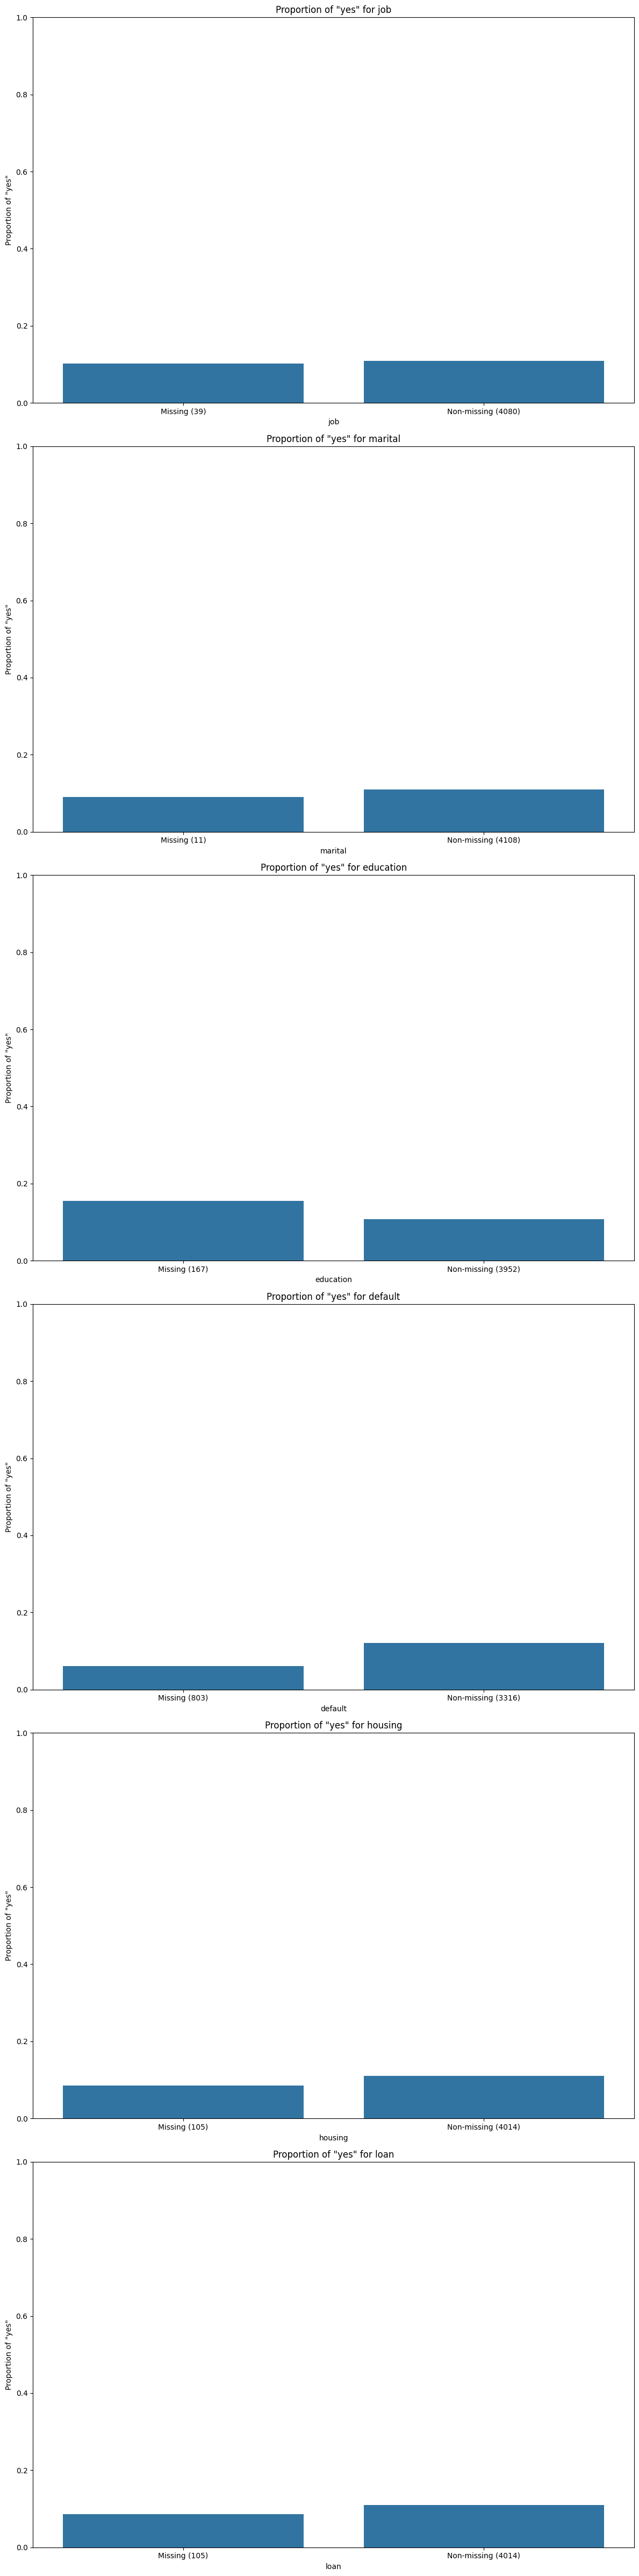

In [3]:
# Function to drop the 'duration' column because it is not known before a call is performed
def drop_duration(data):
    return data.drop('duration', axis=1)

# Function to convert 'yes'/'no' target to binary
def convert_target(data):
    data['y'] = data['y'].map({'yes': 1, 'no': 0})
    return data

# Function to analyze missing values's impact and visualize
def analyze_missing_values(data, missing_values):
    fig, axes = plt.subplots(nrows=len(missing_values.index), ncols=1, figsize=(12, 8 * len(missing_values.index)))

    for ax, col in zip(axes, missing_values.index):
        missing_mask = data[col] == 'unknown'
        total_missing = missing_mask.sum()
        total_non_missing = len(data) - total_missing

        print(f"{col} (missing: {total_missing})")
        proportion = data.groupby(missing_mask)['y'].mean()
        print("Proportion of 'yes' for missing vs non-missing:")
        print(f"Missing: {proportion[True]:.2%}")
        print(f"Non-missing: {proportion[False]:.2%}")

        # Calculate percentage difference
        diff_percentage = (proportion[True] - proportion[False]) * 100
        print(f"Difference in proportion: {diff_percentage:.2f}%")
        print()

        # Visualization with seaborn this time not with the matplotlib bcs yuksel hates it
        sns.barplot(x=[f'Missing ({total_missing})', f'Non-missing ({total_non_missing})'], 
                    y=[proportion[True], proportion[False]], ax=ax)
        ax.set_title(f'Proportion of "yes" for {col}')
        ax.set_ylabel('Proportion of "yes"')
        ax.set_xlabel(col)
        ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()
    return data

# Extract missing values
_, missing_values = check_missing_values(data)

# Create a pipeline
pipeline = Pipeline([
    ('drop_duration', FunctionTransformer(drop_duration)),
    ('convert_target', FunctionTransformer(convert_target)),
    ('analyze_missing_values', FunctionTransformer(analyze_missing_values, kw_args={'missing_values': missing_values}))
])

data = pipeline.fit_transform(data)


| **Column**   | **Missing Count** | **Difference in Proportion of 'Yes'** | **Decision**                                                                                                                                          |
|---------------|-------------------|---------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|
| **job**       | 39               | -0.70%                                | The small difference suggests minimal bias. Imputed missing values with the mode (`most frequent value`).                                                  |
| **marital**   | 11               | -1.86%                                | The difference is small but notable. Imputed missing values with the mode, as the missing rate and impact are low.                                         |
| **education** | 167              | +4.81%                                | Missing values appear to show higher success rates. "unknown" will be encoded as a separate category to capture this distinction.                      |
| **default**   | 803              | -6.02%                                | The larger difference and high missing rate suggest that encoding "unknown" as a separate category might better capture its relationship to the target.   |
| **housing**   | 105              | -2.44%                                | The moderate difference suggests some potential bias. However after further testing with the full dataset (where the proportion is -%0.47), this bias appears to be a result of the random %10 selected more so than the actual impact of the class. Imputed missing values with the mode. |
| **loan**      | 105              | -2.44%                                | Similar situation to **housing** with a proportion of -%0.47, imputed with the mode. *The similarity with housing has been noted for future reference*|




# Final Encoding Decisions and Reasons

| **Variable**     | **Encoding Decision**     | **Reason**                                                                 |
|------------------|---------------------------|---------------------------------------------------------------------------|
| **job**          | One-hot encoding           | "job" is a nominal categorical variable with distinct types; one-hot encoding prevents introducing any ordinal relationships. |
| **marital**      | One-hot encoding           | "marital" is a categorical variable with distinct values and no natural order. One-hot encoding handles it appropriately. |
| **education**    | One-hot encoding           | "education" includes "unknown" as its own category; one-hot encoding treats each category (including `unknown`) as a separate binary column. |
| **default**      | One-hot encoding           | "default" is a binary categorical variable with "no" and "yes" values and additionally includes "unknown" as its own category, so one-hot encoding is appropriate. |
| **housing**      | One-hot encoding           | "housing" is a binary categorical variable with "no" and "yes" values, and one-hot encoding works well here. |
| **loan**         | One-hot encoding           | "loan" is also binary, with "no" and "yes" values, and one-hot encoding is suitable. |
| **contact**      | One-hot encoding           | "contact" is a nominal categorical variable with distinct types ("cellular", "telephone"), making one-hot encoding ideal. |
| **month**        | Cyclical encoding (sin/cos) | "month" is cyclical (e.g., December follows January), so sine and cosine transformations capture its cyclical nature. The complete lack of January and February, alongside the rarity of December has been noted.  |
| **day_of_week**  | One-hot encoding           | "day_of_week" is a nominal categorical variable with distinct values (days of the week) and no inherent order, so one-hot encoding is suitable. The lack of inherent order is due to the nature of this variable relating to many different weeks as opposed to a one week period. |
| **poutcome**     | One-hot encoding           | "poutcome" is categorical with distinct values (e.g., "failure", "success"), and one-hot encoding captures the separate categories. |



In [4]:
def encode_month_sin_cos(X):
    month_map = {'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
                 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    months = X["month"]  # Access column by name
    months = months.map(month_map).fillna(0)  # Map and handle missing
    month_sin = np.sin(2 * np.pi * months / 12)
    month_cos = np.cos(2 * np.pi * months / 12)
    return pd.DataFrame({"month_sin": month_sin, "month_cos": month_cos})

def month_feature_names_out(self, input_features): #this took way too long to figure out jesus christ
    return ["month_sin", "month_cos"]

In [5]:
categorical_impute_cols = ['job', 'marital', 'housing', 'loan']
categorical_pass_cols = ['education', 'default']

onehot_cols = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 
               'day_of_week', 'poutcome', 'education']
numerical_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                  'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# TODO for much later, pdays is one fucking stupid column
# it has 999 as a value which is a placeholder for never contacted, this might be 
# a problem for the model, if so we need to handle this, but first testing the model
#  without handling it

In [6]:
mode_imputer = SimpleImputer(strategy='most_frequent', missing_values='unknown')
month_transformer = FunctionTransformer(encode_month_sin_cos, validate=False, feature_names_out=month_feature_names_out)
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

#Impute
data[categorical_impute_cols] = mode_imputer.fit_transform(data[categorical_impute_cols])

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('month_encoding', month_transformer, ['month']), 
        ('onehot', onehot_encoder, onehot_cols),
        ('scaling', scaler, numerical_cols)
    ],
    remainder='passthrough'  # Keeps other columns as is, keeping response variable
)

transformed_data = preprocessor.fit_transform(data)

In [ ]:
transformed_df = pd.DataFrame(transformed_data, columns=preprocessor.get_feature_names_out())
#print(len(transformed_df.columns))

In [8]:

numerical_corr
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix - Numerical Features")
plt.show()

KeyError: "None of [Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',\n       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],\n      dtype='object')] are in the [columns]"